In [1]:
import numpy as np
import wlcstat.wlc_copoly as wlc_copoly
from scipy.interpolate import interp1d

In [2]:
#FOR VERTEX:
import sys
sys.path.append("./vertex_subroutines")
from GAMcalc import *  # Code for calculating vertex functions
import propagator  # propagator object used to store pre-calculated values
import wignerD as wd # wigner D object used to store pre-calculated values

In [260]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm

In [3]:
pset=propagator.prop_set(nlam=10) 
wigset = wd.wigner_d_vals()

In [20]:
def s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K):
    "returns the annealed disorder average of the 2 point sf inverse of a binary mixture of diblock copolymers"
    "CURRENTLY ONLY HANDLES POLYS OF SAME LENGTH"
    if (N_1 != N_2):
        raise Exception("Can only handle binary mix of polymers with same length")
        
    if norm(K) < 1e-5:
        s2inv = s2inverse_zeroq_polyd(N_1, N_2, PHI_1, PHI_2) #TODO change so handles dif length polys
        return s2inv
    
    #PHI_2 = 1 - PHI_1
    s2_1 = s2wlc(pset, N_1, FA_1, K)
    s2_2 = s2wlc(pset, N_2, FA_2, K)
    
    s2inv = np.zeros((2,2),dtype=type(1+1j))
    
    [s2aa_1, s2ab_1], [s2ba_1, s2bb_1] = s2_1
    [s2aa_2, s2ab_2], [s2ba_2, s2bb_2] = s2_2
    
    s2aa = PHI_1*s2aa_1+PHI_2*s2aa_2 # TODO: update these averages to consider N_1 != N_2
    s2ab = PHI_1*s2ab_1+PHI_2*s2ab_2
    s2ba = PHI_1*s2ba_1+PHI_2*s2ba_2
    s2bb = PHI_1*s2bb_1+PHI_2*s2bb_2
    
    det = s2aa*s2bb - s2ab*s2ba
    
    s2inv[0,0] = s2bb/det
    s2inv[0,1] = -s2ab/det
    s2inv[1,0] = -s2ba/det
    s2inv[1,1] = s2aa/det
    
    return s2inv

In [25]:
def spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2):
    CHI = 0
    if (N_1 != N_2):
        raise Exception("Can only handle binary mix of polymers with same length")
    K0 = 1/np.sqrt(r2(N_1))
    
    KS = optimize.fmin(lambda K: np.real(gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K, CHI)), K0,\
                      disp=False)
    
    return KS

In [22]:
# chemically averaged

def gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K, CHI):
    #Only accepts two polymer types of same length
    #PHI_2 = 1 - PHI_1
    
    s2inv = s2inverse_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, K)

    D = [1,-1]    # sign indicator
    G = 0
    for I0, I1 in product([0,1], repeat=2):
        G += s2inv[I0, I1]*D[I0]*D[I1]
        
    return -2*CHI + (PHI_1*N_1 + PHI_2*N_2)*G #TODO: fix this averaging for polys w different length
# calc spinodal!

In [23]:
def s2inverse_zeroq_polyd(N_1, N_2, PHI_1, PHI_2):
    s2 = np.ones((2,2),dtype='complex')
    N_ave = N_1 * PHI_1 + N_2 * PHI_2
    return s2/(N_ave**2)

In [300]:
def threshold_plot(ax, x, y, threshv, color, overcolor):
    """
    Helper function to plot points above a threshold in a different color

    Parameters
    ----------
    ax : Axes
        Axes to plot to
    x, y : array
        The x and y values

    threshv : float
        Plot using overcolor above this value

    color : color
        The color to use for the lower values

    overcolor: color
        The color to use for values over threshv

    """
    # Create a colormap for red, green and blue and a norm to color
    # f' < -0.5 red, f' > 0.5 blue, and the rest green
    cmap = ListedColormap([color, overcolor])
    norm = BoundaryNorm([np.min(y), threshv, np.max(y)], cmap.N)

    # Create a set of line segments so that we can color them individually
    # This creates the points as a N x 1 x 2 array so that we can stack points
    # together easily to get the segments. The segments array for line collection
    # needs to be numlines x points per line x 2 (x and y)
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)

    # Create the line collection object, setting the colormapping parameters.
    # Have to set the actual values used for colormapping separately.
    lc = LineCollection(segments, cmap=cmap, norm=norm)
    lc.set_array(y)

    ax.add_collection(lc)
    ax.set_xlim(np.min(x), np.max(x))
    ax.set_ylim(np.min(y)*1.1, np.max(y)*1.1)
    return lc

In [13]:
N_1 = 10.

FA_1_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 20, .01)/N_1

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)


# Monodisperse 

In [14]:
%%time
#single component G2 matrix stability analysis, POST INCOMPRESSIBILITY

spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]
    for chi in chi_range:
        chi_spin_bool = False #means spinodal has not been reached
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2 #determinant of s2 matrix
            prefactor_1 = 1/(det_1)[0] #1/2 from taylor expansion, which remains after performing gaussian integral

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1
            
            G2 = (s2inv_AA_1 + 2*s2inv_AB_1 + s2inv_BB_1)-2*chi*N_1
            if G2 <= 0:
                chi_spin_bool = True
                break
        if chi_spin_bool == True:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

Wall time: 28.6 s


In [15]:
%%time
#single component Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(FA_1_arr))
for i, FA in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal(pset, N_1, FA)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2(pset, N_1, FA, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 10.7 s


Text(0.5, 0, '$f_A$')

<Figure size 432x288 with 0 Axes>

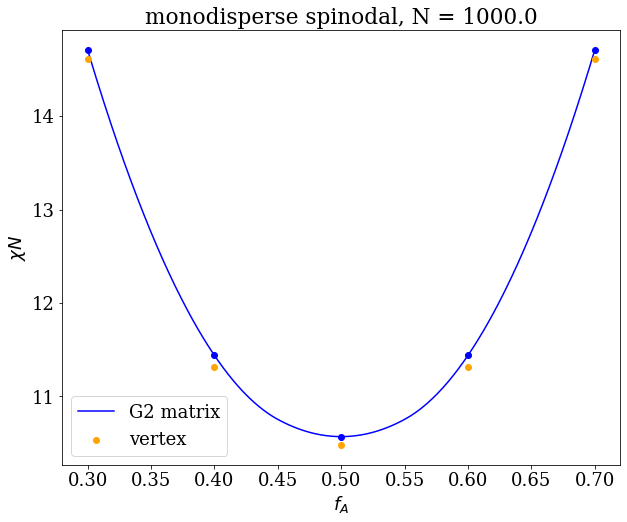

In [16]:
matrixG2_spin_mono_interp = interp1d(FA_1_arr, spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic") 

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.301, 0.7, 0.001)
ax.plot(new_x, matrixG2_spin_mono_interp(new_x), color = "blue", label = "G2 matrix", zorder=1)
# ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "orange", label = "vertex")

ax.scatter(FA_1_arr, spinodal_arr, color = "blue", zorder = 2)
ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "orange", label = "vertex", zorder = 3)
plt.legend()
plt.title("monodisperse spinodal, N = " + str(N_1))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A$")

# Polydisperse binary mix

In [278]:
N_1 = 10.
FA_1_arr = np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7]) #np.arange(0.1, 0.701, 0.05) #np.array([0.01, 0.02, 0.05, 0.1, 0.3, .5, 0.7])#
PHI_1 = 0.5

N_2 = N_1
FA_2 = 0.9
PHI_2 = 0.5

k0 = 1e-2
kf = 1e2
nk = 50

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

chi_range = np.arange(4, 20, 0.01)/N_1

if (PHI_1 + PHI_2 > 1.00001) or (PHI_1 + PHI_2 < 1 - .00001):
    raise Exception("Phis dont add up to 1")

In [239]:
k_vec[0] #
#EEEEEEEEEEEEEEEEEEEEEYEAHHHHHHHHHHHHHH
#0.01 means zero!!!!
#EEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEEYeahyeaheyaYEAHHHHHH

#TODO- if eigvalue == k_arr[0], append to macro spin, else, append to microspin

#change plotting so doing every other, FA and chi combined

0.01

In [285]:
%%time
#binary mix- Vectorized, ASSUMING SAME LENGTH
#TODO- interpreting eigenvalues


# chi_range = np.arange(5.5, 20, 0.001)/N_1


polyd_spinodal_arr = np.array([])
polyd_spinodal_arr_FAS = np.array([])
polyd_spinodal_arr_macro = np.array([])
polyd_spinodal_arr_FAS_macro = np.array([])
eigvects_arr = []
eigvals_arr = []
k_star_arr = []

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]

    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
#         chiN = chi * N
        
        det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
        prefactor_1_arr = 1/(det_1_arr*2*PHI_1)
        
        det_2_arr = s2_AA_2 * s2_BB_2 - s2_AB_2**2
        prefactor_2_arr = 1/(det_2_arr*2*PHI_2)
        
        s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr
        s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr
        s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr
        
        s2inv_AA_2_arr = s2_AA_2*prefactor_2_arr
        s2inv_AB_2_arr = s2_AB_2*prefactor_2_arr
        s2inv_BB_2_arr = s2_BB_2*prefactor_2_arr
        
        #matrix indices
        
        zero_zero = s2inv_BB_1_arr - (chi*N_1) + s2inv_AA_2_arr
        zero_one = -s2inv_AB_1_arr + s2inv_AA_2_arr
        zero_two = -(chi*N_1) + s2inv_AB_2_arr + s2inv_AA_2_arr
        
        one_zero = zero_one
        one_one = s2inv_AA_1_arr + s2inv_AA_2_arr
        one_two = s2inv_AB_2_arr + s2inv_AA_2_arr
        
        two_zero = zero_two
        two_one = one_two
        two_two = s2inv_BB_2_arr + 2*s2inv_AB_2_arr - (chi*N_1) + s2inv_AA_2_arr
        
        G2 = np.array([zero_zero, zero_one, zero_two, one_zero, one_one, one_two, two_zero, two_one, two_two]).T.reshape(len(k_vec), 3, 3)
        eigvalues,eigvectors = np.linalg.eigh(G2)
        eigvalues_lst = np.concatenate(eigvalues)
        min_eig = np.min(eigvalues_lst)
        if min_eig <= 0:
            chi_spin_bool = True
            eigvects = eigvectors[np.where(eigvalues_lst==min_eig)[0]//3][0]
            eigvals = eigvalues[np.where(eigvalues_lst==min_eig)[0]//3][0]
            #identify k_star- index of the eigenvalue list that includes val of zero
            k_star = k_vec[np.where(eigvalues_lst==min_eig)[0]//3][0]
            break
    if chi_spin_bool == True:
        eigvals_arr.append(eigvals)
        eigvects_arr.append(eigvects)
        k_star_arr.append(k_star)
        if k_star == k_vec[0]:
            polyd_spinodal_arr_macro = np.append(polyd_spinodal_arr_macro, chi*N_1)
            polyd_spinodal_arr_FAS_macro = np.append(polyd_spinodal_arr_FAS_macro, FA_1)
#         else:
#             polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#             polyd_spinodal_arr_FAS = np.append(polyd_spinodal_arr_FAS, FA_1)
        polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
    else:
        raise Exception("chi range not high enough")
eigvals_arr = np.array(eigvals_arr)
eigvects_arr = np.array(eigvects_arr)
k_star_arr = np.array(k_star_arr)
#NON VECT- 2min 52 sec
# VECT - 1min 15 sec

Wall time: 1min 31s


In [ ]:
k_star_arr 

In [248]:
FA_1_arr

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

# Annealed disorder avg results

In [292]:
%%time
#annealed disorder avg binary mix Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex_polyd_anneal = np.zeros(len(FA_1_arr))
for i, FA_1 in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2_polyd(pset, N_1, N_2, FA_1, FA_2, PHI_1, PHI_2, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex_polyd_anneal[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 8.62 s


# Monodisperse Vertex spinodal 
for comparison

In [293]:
%%time
#single component Vertex spinodal


#generate spinodal
# N = N_1
# f_as = FA_1_arr #= np.arange(0.2, 0.505, .02)#np.arange(0.1, 1, 0.1)
spin_array_vertex = np.zeros(len(FA_1_arr))
for i, FA_1 in enumerate(FA_1_arr):
    chis = chi_range 
    min_G_vals = np.zeros(len(chis))
    KS = spinodal(pset, N_1, FA_1)
    for j,CHI in enumerate(chis):
        #evaluate gamma2 at the chi k_spinodal for appropriate length, find when equals zero
        G = gamma2(pset, N_1, FA_1, KS, CHI)
        min_G_vals[j] = G # b/c g2 is 1x1 matrix, eigenvalue is the value of g2 itself. 
#     print("chis: ", chis)
#     print("g val/ eigv: ", min_G_vals)
    spin_array_vertex[i] = chis[np.argmin((abs(min_G_vals)))]


<timed exec>:15: ComplexWarning: Casting complex values to real discards the imaginary part


Wall time: 15.5 s


# Plotting

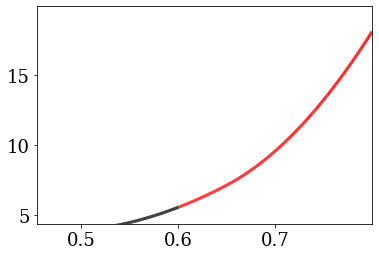

In [301]:
fig, ax = plt.subplots()

x = fa_eff
y = matrixG2_spin_polyd_interp(new_x_lil)

lc = threshold_plot(ax, x, y,  polyd_spinodal_arr_macro[-1], 'k', 'r')
# ax.axhline(.75, color='k', ls='--')
lc.set_linewidth(3)

In [289]:
polyd_spinodal_arr_FAS_macro

array([0.01, 0.02, 0.05, 0.1 , 0.3 ])

In [290]:
polyd_spinodal_arr_macro

array([4.  , 4.  , 4.  , 4.  , 5.56])

In [298]:
 polyd_spinodal_arr_macro

array([4.  , 4.  , 4.  , 4.  , 5.56])

(0.3, 0.8)

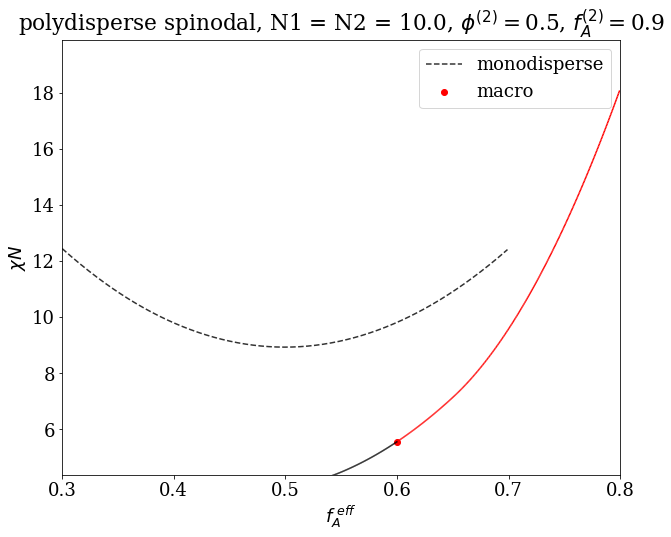

In [304]:
#FA EFF
matrixG2_spin_polyd_interp = interp1d(FA_1_arr, polyd_spinodal_arr, kind="quadratic") 
# matrixG2_spin_polyd_interp_macro = interp1d(polyd_spinodal_arr_macro_FAS, polyd_spinodal_arr_macro, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic")
vertex_spin_interp_polyd_anneal = interp1d(FA_1_arr, spin_array_vertex_polyd_anneal*N_1, kind="quadratic")

# fig, ax = plt.subplots()
# fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.300, 0.70, 0.001)

new_x_lil = np.arange(0.01, 0.70, 0.001)

fa_eff = PHI_1 * new_x_lil + PHI_2 * FA_2


# ax.plot(fa_eff, matrixG2_spin_polyd_interp(new_x_lil), color = "blue", label = "exact", zorder = 0)
x = fa_eff
y = matrixG2_spin_polyd_interp(new_x_lil)

lc = threshold_plot(ax, x, y,  polyd_spinodal_arr_macro[-1], 'k', 'r')


ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "black", linestyle = "--", label = "monodisperse", alpha = 0.8)
# ax.plot(fa_eff, vertex_spin_interp_polyd_anneal(new_x), color = "orange",  label = "annealed")

# ax.plot( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue", label = "exact")
ax.scatter( PHI_1 * polyd_spinodal_arr_FAS_macro + PHI_2 * FA_2, polyd_spinodal_arr_macro, color = "red", label = "macro")
# ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "black", label = "monodisperse", zorder = 1)
# ax.scatter(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange", label = "annealed", zorder = 1)

# ax.plot( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue")#, label = "exact")
# ax.plot(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange")#, label = "annealed", zorder = 1)


plt.legend()
plt.title("polydisperse spinodal, N1 = N2 = " + str(N_1) + ", $\phi^{(2)} = $" + str(PHI_2) + ", $f_A^{(2)} = $" + str(FA_2))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\ eff}$")

# plt.ylim(10, 12.5)
plt.xlim(0.3, 0.8)

Text(0.5, 0, '$f_A^{\\ eff}$')

<Figure size 432x288 with 0 Axes>

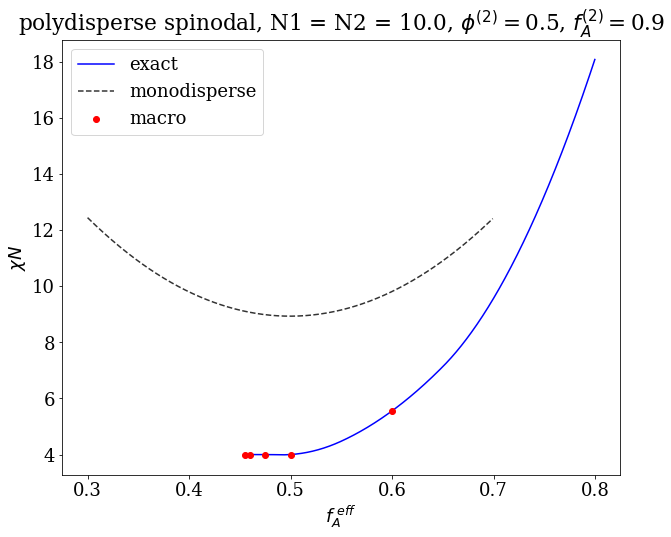

In [297]:
#FA EFF
matrixG2_spin_polyd_interp = interp1d(FA_1_arr, polyd_spinodal_arr, kind="quadratic") 
# matrixG2_spin_polyd_interp_macro = interp1d(polyd_spinodal_arr_macro_FAS, polyd_spinodal_arr_macro, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic")
vertex_spin_interp_polyd_anneal = interp1d(FA_1_arr, spin_array_vertex_polyd_anneal*N_1, kind="quadratic")

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.300, 0.70, 0.001)

new_x_lil = np.arange(0.01, 0.70, 0.001)

fa_eff = PHI_1 * new_x_lil + PHI_2 * FA_2
ax.plot(fa_eff, matrixG2_spin_polyd_interp(new_x_lil), color = "blue", label = "exact", zorder = 0)
ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "black", linestyle = "--", label = "monodisperse", alpha = 0.8)
# ax.plot(fa_eff, vertex_spin_interp_polyd_anneal(new_x), color = "orange",  label = "annealed")

# ax.plot( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue", label = "exact")
ax.scatter( PHI_1 * polyd_spinodal_arr_FAS_macro + PHI_2 * FA_2, polyd_spinodal_arr_macro, color = "red", label = "macro")
# ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "black", label = "monodisperse", zorder = 1)
# ax.scatter(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange", label = "annealed", zorder = 1)

# ax.plot( PHI_1 * FA_1_arr + PHI_2 * FA_2, polyd_spinodal_arr, color = "blue")#, label = "exact")
# ax.plot(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange")#, label = "annealed", zorder = 1)


plt.legend()
plt.title("polydisperse spinodal, N1 = N2 = " + str(N_1) + ", $\phi^{(2)} = $" + str(PHI_2) + ", $f_A^{(2)} = $" + str(FA_2))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{\ eff}$")

# plt.ylim(10, 12.5)
# plt.xlim(0.3, 0.5)

In [264]:
polyd_spinodal_ar

array([ 5.56,  7.13,  7.99,  8.7 ,  9.42, 10.61, 12.5 ])

In [ ]:
#F_A 1
matrixG2_spin_polyd_interp = interp1d(FA_1_arr, polyd_spinodal_arr, kind="quadratic") 
vertex_spin_mono_interp = interp1d(FA_1_arr, spin_array_vertex*N_1, kind="quadratic")
# vertex_spin_interp_polyd_anneal = interp1d(FA_1_arr, spin_array_vertex_polyd_anneal*N_1, kind="quadratic")

fig = plt.figure()
plt.figure(figsize=(10,8))

font = {'family' : 'serif',
        'weight':'normal',
        'size': 18}
plt.rc('font', **font)
ax = plt.subplot(111)

new_x = np.arange(0.300, 0.50, 0.001)

ax.plot(new_x, matrixG2_spin_polyd_interp(new_x), color = "blue", label = "exact", zorder = 0)
ax.plot(new_x, vertex_spin_mono_interp(new_x), color = "black", linestyle = "--", label = "monodisperse", alpha = 0.8)
# ax.plot(fa_eff, vertex_spin_interp_polyd_anneal(new_x), color = "orange",  label = "annealed")

# ax.scatter(FA_1_arr, polyd_spinodal_arr, color = "blue", label = "exact")
# ax.scatter(FA_1_arr, spin_array_vertex*N_1, color = "black", label = "monodisperse", zorder = 1)
# ax.scatter(PHI_1 * FA_1_arr + PHI_2 * FA_2, spin_array_vertex_polyd_anneal*N_1, color = "orange", label = "annealed", zorder = 1)

plt.legend()
plt.title("polydisperse spinodal, N1 = N2 = " + str(N_1) + ", $\phi^{(2)} = $" + str(PHI_2) + ", $f_A^{(2)} = $" + str(FA_2))
ax.set_ylabel("$\chi N$")
ax.set_xlabel("$f_A^{(1)}$")

# plt.ylim(10, 13)
# plt.xlim(0.3, 0.5)

In [ ]:
#old cells

In [ ]:
%%time
#single component G2 matrix stability analysis. ISSUE: needed to apply incompressibility

N_1 = 10.

k0 = 1e-2
kf = 1e2
nk = 50
k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

FA_arr = np.arange(0.3, 0.71, 0.1)
chi_range = np.arange(8, 13, .01)/N_1

spinodal_arr = np.array([]) 

for FA_1 in FA_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]
    for chi in chi_range:
        chi_spin_bool = False #means spinodal has not been reached
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2 #determinant of s2 matrix
            prefactor_1 = 1/(det_1*2)[0] #1/2 from taylor expansion, which remains after performing gaussian integral

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

            G2 = (1/N_1)*np.array([[s2inv_BB_1, -s2inv_AB_1 + 0.5*chi*N_1], [-s2inv_AB_1 + 0.5*chi*N_1, s2inv_AA_1]]) #single poly type
            
            eigvalues,eigvectors = np.linalg.eigh(G2)
            min_eig = np.min(eigvalues)
            if min_eig <= 0:
                chi_spin_bool = True
                break
#             if eigvalues[0] < 0 and eigvalues[1] < 0:
#                 chi_spin_bool = True
#                 break
    #         determ = np.linalg.det(G2)
    #         if determ <= 0 :

    #             chi_spin_bool = True
    #             break
        if chi_spin_bool == True:
            spinodal_arr = np.append(spinodal_arr,  chi*N_1)
            break

In [ ]:
%%time
#binary mix- incompressibility applied, 4x4 -> 3x3. ASSUMING SAME LENGTH. NON vectorized
#TODO- make for a range of F_A
N_1 = 10.
# FA_1 = 0.7
FA_1_arr = np.arange(0.3, 0.71, 0.1)
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.7
PHI_2 = 0.00001

k0 = 1e-2
kf = 1e2
nk = 50

chi_range = np.arange(5.5, 20, 0.001)/N_1

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

polyd_spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]


    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
        chiN = chi * N
        for k_ind in range(len(k_vec)):
            det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2
            prefactor_1 = 1/(det_1 * 2 * PHI_1)[0]

            det_2 = s2_AA_2[k_ind] * s2_BB_2[k_ind] - s2_AB_2[k_ind]**2
            prefactor_2 = 1/(det_2 * 2 * PHI_2)[0]

            s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
            s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
            s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

            s2inv_AA_2 = s2_2[0][k_ind][0]*prefactor_2
            s2inv_AB_2 = s2_2[1][k_ind][0]*prefactor_2
            s2inv_BB_2 = s2_2[2][k_ind][0]*prefactor_2

            G2 = [[s2inv_BB_1 - (chi*N_1) + s2inv_AA_2, -s2inv_AB_1 + s2inv_AA_2, -(chi*N_1) + s2inv_AB_2 + s2inv_AA_2], \
                  [-s2inv_AB_1 + s2inv_AA_2, s2inv_AA_1 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2], \
                  [-(chi*N_1) + s2inv_AB_2 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2, s2inv_BB_2 + 2*s2inv_AB_2 - (chi*N_1) + s2inv_AA_2]]

            eigvalues,eigvectors = np.linalg.eigh(G2)
            min_eig = np.min(eigvalues)
            if min_eig <= 0:
                chi_spin_bool = True
                break
        if chi_spin_bool == True:
            polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
            break

In [ ]:
%%time
#binary mix- Vectorized, ASSUMING SAME LENGTH but can handle different lengths- dont know how to deal with XN y-axis
#TODO- make for a range of F_A
N_1 = 10.
# FA_1 = 0.7
FA_1_arr = np.arange(0.3, 0.71, 0.1)
PHI_1 = 0.99999

N_2 = N_1
FA_2 = 0.7
PHI_2 = 0.00001

k0 = 1e-2
kf = 1e2
nk = 50

# chi_range = np.arange(5.5, 20, 0.001)/N_1

chi_range = np.arange(7, 15, 0.01)/N_1

k_vec = np.logspace(np.log10(k0), np.log10(kf), nk)

polyd_spinodal_arr = np.array([]) 

for FA_1 in FA_1_arr:
    s2_1 = wlc_copoly.s2_wlc_diblock(k_vec, N_1, FA_1, dimensions=3, alpha_max=25)

    s2_AA_1 = s2_1[0]
    s2_AB_1 = s2_1[1]
    s2_BB_1 = s2_1[2]

    s2_2 = wlc_copoly.s2_wlc_diblock(k_vec, N_2, FA_2, dimensions=3, alpha_max=25)

    s2_AA_2 = s2_2[0]
    s2_AB_2 = s2_2[1]
    s2_BB_2 = s2_2[2]

    for chi in chi_range:
    #     print("chi: ", chi)
        chi_spin_bool = False #means spinodal has not been reached
        chiN = chi * N
        
        det_1_arr = s2_AA_1 * s2_BB_1 - s2_AB_1**2
        prefactor_1_arr = 1/(det_1_arr*2*PHI_1)
        
        det_2_arr = s2_AA_2 * s2_BB_2 - s2_AB_2**2
        prefactor_2_arr = 1/(det_2_arr*2*PHI_2)
        
        s2inv_AA_1_arr = s2_AA_1*prefactor_1_arr/N_1
        s2inv_AB_1_arr = s2_AB_1*prefactor_1_arr/N_1
        s2inv_BB_1_arr = s2_BB_1*prefactor_1_arr/N_1
        
        s2inv_AA_2_arr = s2_AA_2*prefactor_2_arr/N_2
        s2inv_AB_2_arr = s2_AB_2*prefactor_2_arr/N_2
        s2inv_BB_2_arr = s2_BB_2*prefactor_2_arr/N_2
        
        #matrix indices
        
        zero_zero = s2inv_BB_1_arr - (chi) + s2inv_AA_2_arr
        zero_one = -s2inv_AB_1_arr + s2inv_AA_2_arr
        zero_two = -(chi) + s2inv_AB_2_arr + s2inv_AA_2_arr
        
        one_zero = zero_one
        one_one = s2inv_AA_1_arr + s2inv_AA_2_arr
        one_two = s2inv_AB_2_arr + s2inv_AA_2_arr
        
        two_zero = zero_two
        two_one = one_two
        two_two = s2inv_BB_2_arr + 2*s2inv_AB_2_arr - (chi) + s2inv_AA_2_arr
        
        G2 = np.array([zero_zero, zero_one, zero_two, one_zero, one_one, one_two, two_zero, two_one, two_two]).T.reshape(len(k_vec), 3, 3)
        eigvalues,eigvectors = np.linalg.eigh(G2)
        eigvalues = np.concatenate(eigvalues)
        min_eig = np.min(eigvalues)
        if min_eig <= 0:
            chi_spin_bool = True
            break
    if chi_spin_bool == True:
        polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#         for k_ind in range(len(k_vec)):
#             det_1 = s2_AA_1[k_ind] * s2_BB_1[k_ind] - s2_AB_1[k_ind]**2
#             prefactor_1 = 1/(det_1 * 2 * PHI_1)[0]

#             det_2 = s2_AA_2[k_ind] * s2_BB_2[k_ind] - s2_AB_2[k_ind]**2
#             prefactor_2 = 1/(det_2 * 2 * PHI_2)[0]

#             s2inv_AA_1 = s2_1[0][k_ind][0]*prefactor_1
#             s2inv_AB_1 = s2_1[1][k_ind][0]*prefactor_1
#             s2inv_BB_1 = s2_1[2][k_ind][0]*prefactor_1

#             s2inv_AA_2 = s2_2[0][k_ind][0]*prefactor_2
#             s2inv_AB_2 = s2_2[1][k_ind][0]*prefactor_2
#             s2inv_BB_2 = s2_2[2][k_ind][0]*prefactor_2

#             G2 = [[s2inv_BB_1 - (chi*N_1) + s2inv_AA_2, -s2inv_AB_1 + s2inv_AA_2, -(chi*N_1) + s2inv_AB_2 + s2inv_AA_2], \
#                   [-s2inv_AB_1 + s2inv_AA_2, s2inv_AA_1 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2], \
#                   [-(chi*N_1) + s2inv_AB_2 + s2inv_AA_2, s2inv_AB_2 + s2inv_AA_2, s2inv_BB_2 + 2*s2inv_AB_2 - (chi*N_1) + s2inv_AA_2]]

#             eigvalues,eigvectors = np.linalg.eigh(G2)
#             min_eig = np.min(eigvalues)
#             if min_eig <= 0:
#                 chi_spin_bool = True
#                 break
#         if chi_spin_bool == True:
#             polyd_spinodal_arr = np.append(polyd_spinodal_arr, chi*N_1)
#             break
#NON VECT- 2min 52 sec
# VECT - 1min 15 sec

polyd_spinodal_arr